# Train ANN and find UCM space by sampling

2019-07-27

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns

import ipdb as pdb
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from time import time
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

tf.compat.v1.random.set_random_seed(0)
np.random.seed(0)

2.0.0-beta1


## Settings

In [2]:
spkr_data = 'JW12.pckl'
n_components = 3  # PCA
input_dim = n_components
output_dim = 2

BATCH_SIZE = 10
TEST_SIZE = 0.2  # 0-1
MAX_EPOCH = 100
n_display = 10 # log every 10th
n_patience = 30 # for early stopping

model_file = 'forward_model.h5'

In [3]:
# Load speaker data
with open(spkr_data, 'rb') as f:
    SPKR = pickle.load(f)
    
SPKR.head()

,Subj,FName,PreLab,NexLab,Label,Context,Dur,T1x,T1y,T2x,...,segEnd,GONS,NONS,MAXC,NOFFS,GOFFS,GesTarDur,timeMidWithinGest,timeMid2GestDiff,GestFound
0,JW12,JW12_TP007,P,N,AE1,P-AE1-N,0.119728,-15.086,-1.4980,-29.573500,...,5.962424,5.801770,5.884162,5.904760,5.918492,5.966554,0.034330,1.0,0.000000,1
1,JW12,JW12_TP010,HH,D,AE1,HH-AE1-D,0.099773,-17.583,3.0545,-30.327500,...,6.339805,6.076410,6.186266,6.206864,6.241194,6.378514,0.054928,0.0,0.048724,1
2,JW12,JW12_TP017,N,S,AE1,N-AE1-S,0.119728,-10.927,-0.0570,-25.707001,...,1.635277,1.380066,1.510520,1.592912,1.613510,1.682170,0.102990,1.0,0.000000,1
3,JW12,JW12_TP017,K,R,AE1,K-AE1-R,0.079819,-22.037,12.3780,-33.766001,...,2.283803,2.100996,2.300110,2.320708,2.348172,2.444296,0.048062,0.0,0.056216,1
4,JW12,JW12_TP017,IY0,N,AE1,IY0-AE1-N,0.049887,-15.916,7.5980,-29.587999,...,2.583123,2.492358,2.602214,2.615946,2.636544,2.705204,0.034330,0.0,0.044035,1


In [4]:
SPKR.columns

Index(['Subj', 'FName', 'PreLab', 'NexLab', 'Label', 'Context', 'Dur', 'T1x',
       'T1y', 'T2x', 'T2y', 'T3x', 'T3y', 'T4x', 'T4y', 'ULx', 'ULy', 'LLx',
       'LLy', 'MNIx', 'MNIy', 'F0', 'F1', 'F2', 'F3', 'A1', 'A2', 'A3',
       'segStart', 'segEnd', 'GONS', 'NONS', 'MAXC', 'NOFFS', 'GOFFS',
       'GesTarDur', 'timeMidWithinGest', 'timeMid2GestDiff', 'GestFound'],
      dtype='object')

## Prepare data
- Extract data
- PCA on X and then zscore
- zscore on y
- tf.data

In [5]:
# Raw X, y data
X_raw = SPKR[['T1x','T1y', 'T2x', 'T2y', 'T3x', 'T3y', 'T4x', 'T4y', 'ULx', 'ULy', 'LLx','LLy', 'MNIx', 'MNIy']].values
y_raw = SPKR[['F1', 'F2']].values

print('X shape', X_raw.shape)
print('y shape', y_raw.shape)

X shape (945, 14)
y shape (945, 2)


In [6]:
# PCA on X --> zscore
pca = PCA(n_components)
pca.fit(X_raw)
X_pc = pca.transform(X_raw)
X_scaler = StandardScaler()
X_scaler.fit(X_pc)
X = X_scaler.transform(X_pc)

print(X.shape, X.mean(axis=0), X.std(axis=0))

(945, 3) [ 1.13959400e-16 -5.36490311e-16 -2.40842032e-17] [1. 1. 1.]


In [7]:
# zscore on y
Y_scaler = StandardScaler()
Y_scaler.fit(y_raw)
Y = Y_scaler.transform(y_raw)

print(Y.shape, Y.mean(axis=0), Y.std(axis=0))

(945, 2) [-3.0075883e-16  9.0227649e-17] [1. 1.]


In [8]:
# Get y label for stratifying testset
ylab = SPKR.Label.values.tolist()
print('Y labels:', len(ylab))

Y labels: 945


In [9]:
# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=TEST_SIZE, random_state=0, 
                                                    stratify=ylab)

print('X train, Y_train:', X_train.shape, Y_train.shape)
print('X test, Y_test:', X_test.shape, Y_test.shape)

X train, Y_train: (756, 3) (756, 2)
X test, Y_test: (189, 3) (189, 2)


In [10]:
def make_dataset(x_data, y_data, is_training=True):
    '''Make dataset object
    '''
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    if is_training:
        dataset = dataset.shuffle(len(x_data))
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.repeat()
    return dataset

In [11]:
# Make dataset objects
train_dataset = make_dataset(X_train, Y_train, is_training=True)
test_dataset = make_dataset(X_test, Y_test, is_training=False)

W0727 22:00:43.334278 4504118720 deprecation.py:323] From /Users/jaegukang/anaconda3/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Train

In [12]:
def build_model():
    '''Build fc model'''
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(10, input_shape=(input_dim,), activation='tanh', use_bias=True, kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(output_dim, activation='linear', use_bias=True, kernel_initializer='glorot_uniform'))
    return model

class NBatchLogger(tf.keras.callbacks.Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.epoch = 0
        self.display = display
        self.logs = {}

    def on_epoch_end(self, epoch, logs={}):
        self.epoch += 1
        if self.epoch % self.display == 0:
            print(f'Epoch: {self.epoch}/{MAX_EPOCH} ... loss:{logs["loss"]:4f} acc:{logs["accuracy"]:4f} ', end='')
            print(f'val_loss:{logs["val_loss"]:.4f} val_acc:{logs["val_accuracy"]:.4f}', end='\n')
        self.logs = logs
        
    def on_train_end(self, logs={}):
        logs = logs or self.logs
        print(f'Epoch: {self.epoch}/{MAX_EPOCH} ... loss:{logs["loss"]:4f} acc:{logs["accuracy"]:4f} ', end='')
        print(f'val_loss:{logs["val_loss"]:.4f} val_acc:{logs["val_accuracy"]:.4f}', end='\n')

In [13]:
model = build_model()
model.compile(optimizer='Adam',
              loss='mse',
              metrics=['accuracy', 'mse'])
print('Model compiled')

Model compiled


In [14]:
t0 = time()
hist = model.fit(train_dataset, epochs=MAX_EPOCH, steps_per_epoch=len(X_train) // BATCH_SIZE,
                 validation_data=test_dataset, validation_steps=len(Y_train) // BATCH_SIZE,
                 callbacks=[
                     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_patience),
                     tf.keras.callbacks.ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True),
                     NBatchLogger(n_display)
                 ],
                 verbose=0)
t1 = time()
print(f'Time elapsed: {(t1-t0)/60:.4f} min') # 7.5 min (gpu)

Epoch: 10/100 ... loss:0.327284 acc:0.877333 val_loss:0.2317 val_acc:0.9013
Epoch: 20/100 ... loss:0.264067 acc:0.902667 val_loss:0.2090 val_acc:0.9013
Epoch: 30/100 ... loss:0.238598 acc:0.902667 val_loss:0.2027 val_acc:0.9013
Epoch: 40/100 ... loss:0.243642 acc:0.889333 val_loss:0.1998 val_acc:0.9067
Epoch: 50/100 ... loss:0.223747 acc:0.902667 val_loss:0.1999 val_acc:0.9000
Epoch: 60/100 ... loss:0.216373 acc:0.904000 val_loss:0.1985 val_acc:0.9107
Epoch: 70/100 ... loss:0.206377 acc:0.901333 val_loss:0.2006 val_acc:0.8987
Epoch: 73/100 ... loss:0.208244 acc:0.900000 val_loss:0.2006 val_acc:0.9107
Time elapsed: 0.6256 min


In [15]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse'])

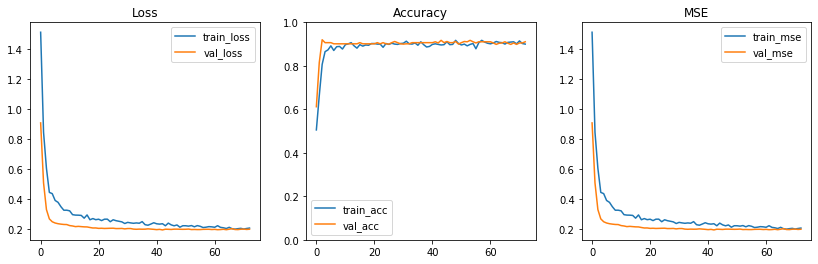

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,4), facecolor='white')
# Loss
ax1.set_title('Loss')
ax1.plot(hist.history['loss'], label='train_loss')
ax1.plot(hist.history['val_loss'], label='val_loss')
ax1.legend()
# Accuracy
ax2.set_title('Accuracy')
ax2.plot(hist.history['accuracy'], label='train_acc')
ax2.plot(hist.history['val_accuracy'], label='val_acc')
ax2.set_ylim([0,1])
ax2.legend()
# MSE
ax3.set_title('MSE')
ax3.plot(hist.history['mse'], label='train_mse')
ax3.plot(hist.history['val_mse'], label='val_mse')
ax3.legend()

## Test the model

In [17]:
def pca_forward_plot(pc1, pc2, pc3):
    '''Plot forward mapping from PCs'''
    x = np.array([[pc1, pc2,pc3]])

    fig = plt.figure(facecolor='white', figsize=(15, 6))
    
    ### PCA space ###
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(pc1, pc2, pc3, c='black')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax1.set_xlim([-r, r])
    ax1.set_ylim([-r, r])
    ax1.set_zlim([-r, r])
    ax1.set_title('PCA space', fontsize=25)

    ### F1-F2 space ###
    # Estimate F1, F2
    y_scaled = model.predict(x)
    y = Y_scaler.inverse_transform(y_scaled).squeeze()
    F1, F2 = y[0], y[1]
    
    # Draw F1, F2
    ax2 = fig.add_subplot(122)
    ax2.plot(F2, F1, marker='o', markersize=5, color='red')
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    ax2.set_xlim([2100, 800])
    ax2.set_ylim([700, 200])
    ax2.set_title('F1-F2 space', fontsize=25)
    ax2.minorticks_on()
    ax2.set_axisbelow(True)
    ax2.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

In [18]:
# Input range
r = 3

interactive_plot = interactive(pca_forward_plot, 
                               pc1=(-r,r,0.1), pc2=(-r,r,0.1), pc3=(-r,r,0.1),continuous_update=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='pc1', max=3.0, min=-3.0), FloatSlider(value=0.0, des…

## Identify possible X combinations given Y

In [19]:
target = np.array([[300, 1800]]) # y target

r = 4  # PC range
th = 10  # threshold for formants (Hz)
n_sample = 30

pc1 = np.linspace(-r, r, n_sample)
pc2 = np.linspace(-r, r, n_sample)
pc3 = np.linspace(-r, r, n_sample)

# Get all combinations
C = list(product(*[pc1, pc2, pc3]))

print('Possible combinations:', len(C))

Possible combinations: 27000


In [25]:
def rmse(pred, target):
    return np.sqrt(((pred - target) ** 2).mean())

# Iterate over combinations
err = []
val = []
for i in tqdm_notebook(range(len(C))):
    c = C[i]

    y_ = model.predict(np.array([c]))
    y = Y_scaler.inverse_transform(y_)
    
    e = rmse(y, target)
    if e < th:
        err.append(e)
        val.append(c)

44/27000 are below threshold (10 Hz)



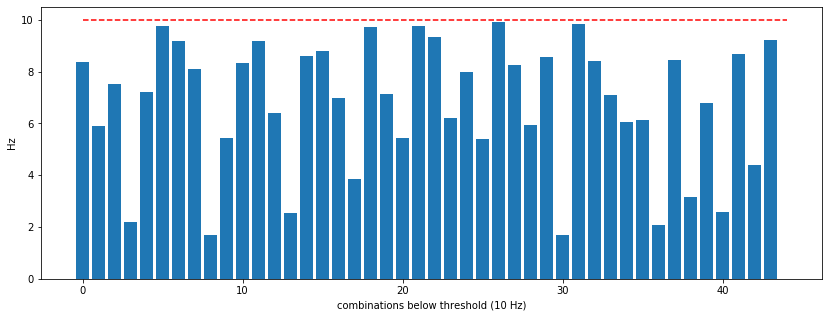

In [29]:
show_plot = True

if show_plot:
    fig, ax = plt.subplots(figsize=(14,5), facecolor='white')
    ax.bar(range(len(err)), err);
    ax.plot([0, len(val)], [th, th], 'r--')
    ax.set_ylabel('RMSE (Hz)')
    ax.set_xlabel(f'combinations below threshold ({th} Hz)')

print(f'{len(idx)}/{len(out)} are below threshold ({th} Hz)\n')

## Visualize

In [36]:
def pca_combination_plot(i):
    '''Plot forward mapping from PCs'''
    pc1, pc2, pc3 = val[i]
    x = np.array(val[i]).reshape((1, -1))
    val_ = np.array(val)

    fig = plt.figure(facecolor='white', figsize=(15, 6))
    ### PCA space ###
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(val_[:,0], val_[:,1], val_[:,2], 'ko')
    ax1.scatter(pc1, pc2, pc3, c='r', zorder=10)
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax1.set_xlim([-r, r])
    ax1.set_ylim([-r, r])
    ax1.set_zlim([-r, r])
    ax1.set_title('PCA space', fontsize=25)

    ### F1-F2 space ###
    # Estimate F1, F2
    y_scaled = model.predict(x)
    y = Y_scaler.inverse_transform(y_scaled).squeeze()
    F1, F2 = y[0], y[1]
    # Draw F1, F2
    ax2 = fig.add_subplot(122)
    ax2.plot(target.squeeze()[1], target.squeeze()[0], marker='o', color='red')
    ax2.plot(F2, F1, marker='o', markersize=5, color='black')
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    ax2.set_xlim([2100, 800])
    ax2.set_ylim([700, 200])
    ax2.set_title('F1-F2 space', fontsize=25)
    ax2.minorticks_on()
    ax2.set_axisbelow(True)
    ax2.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

In [37]:
# Input range
interactive_plot = interactive(pca_combination_plot, 
                               i=(0, len(candidate)-1, 1),continuous_update=True)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=21, description='i', max=43), Output()), _dom_classes=('widget-interact'…

# Explore the method of optimizing the inputs given outputs --> `2019-07-27_train_inputs.ipynb`